# Imports

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import json
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import datetime, timedelta
import pickle

# Avalanche data

In [ ]:
file_path = 'drive/MyDrive/Colab/eaws.csv'
df = pd.read_csv(file_path, delimiter=';')

df

,id,datetime,loc_name,country,fatal,group_activity,slope_activity,lat,lon,loc_elevation,...,av_length,av_thickness,group_size,av_problem1,av_problem2,danger_pattern1,danger_pattern2,av_size,av_type,danger_level
0,3,2019-11-09 12:06:00,Rettenbachferner,Austria,2.0,Off-piste skiing,Descending,46.935601,10.937191,2850.0,...,300.0,60.0,3.0,Persistent weak layer,Wind slab,1.0,6.0,2.0,slab,NaN
1,4,2019-12-31 13:30:00,Gamskarspitze,Austria,1.0,Mountaineering/Climbing,Descending,47.120100,10.314100,2450.0,...,1050.0,100.0,4.0,Persistent weak layer,NaN,7.0,NaN,3.0,slab,2
2,6,2020-02-09 11:40:00,Murkarspitze,Austria,1.0,Backcountry skiing,Descending,47.025348,11.036651,3020.0,...,400.0,60.0,8.0,Persistent weak layer,NaN,4.0,7.0,2.0,slab,2
3,19,2019-11-17 12:00:00,"Bobojach, Eselrücken",Austria,NaN,NaN,NaN,47.027993,12.415425,2450.0,...,500.0,NaN,NaN,Gliding snow,Wind slab,2.0,NaN,4.0,glide,4
4,20,2019-11-17 00:00:00,"Gorner, Umlaufseilbahn Kals, Adlerslounge",Austria,NaN,NaN,NaN,46.987867,12.608574,2500.0,...,1200.0,100.0,NaN,New snow,Wind slab,6.0,NaN,4.0,slab,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,3161,2024-04-25 10:00:00,arête de Tricot,France,1.0,Mountaineering/Climbing,NaN,45.847700,6.789600,2300.0,...,NaN,NaN,2.0,Wind slab,Wet snow,NaN,NaN,NaN,loose,2
2602,3162,2024-04-29 12:30:00,Piz Platta,Switzerland,1.0,NaN,NaN,46.485910,9.562120,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2603,3163,2024-04-25 15:50:00,Biv Colombo - M. Cevedale,Italy,1.0,Backcountry skiing,Descending,46.448083,10.614139,3500.0,...,100.0,60.0,4.0,Wind slab,New snow,NaN,NaN,2.0,slab,2
2604,3164,2024-05-05 12:00:00,Piz Bernina,Switzerland,1.0,NaN,NaN,46.382540,9.937960,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2606 entries, 0 to 2605
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2606 non-null   int64  
 1   datetime         2606 non-null   object 
 2   loc_name         734 non-null    object 
 3   country          2601 non-null   object 
 4   fatal            2497 non-null   float64
 5   group_activity   2524 non-null   object 
 6   slope_activity   481 non-null    object 
 7   lat              734 non-null    float64
 8   lon              734 non-null    float64
 9   loc_elevation    456 non-null    float64
 10  loc_aspect       524 non-null    object 
 11  loc_angle        322 non-null    float64
 12  av_width         254 non-null    float64
 13  av_length        270 non-null    float64
 14  av_thickness     181 non-null    float64
 15  group_size       619 non-null    float64
 16  av_problem1      519 non-null    object 
 17  av_problem2   

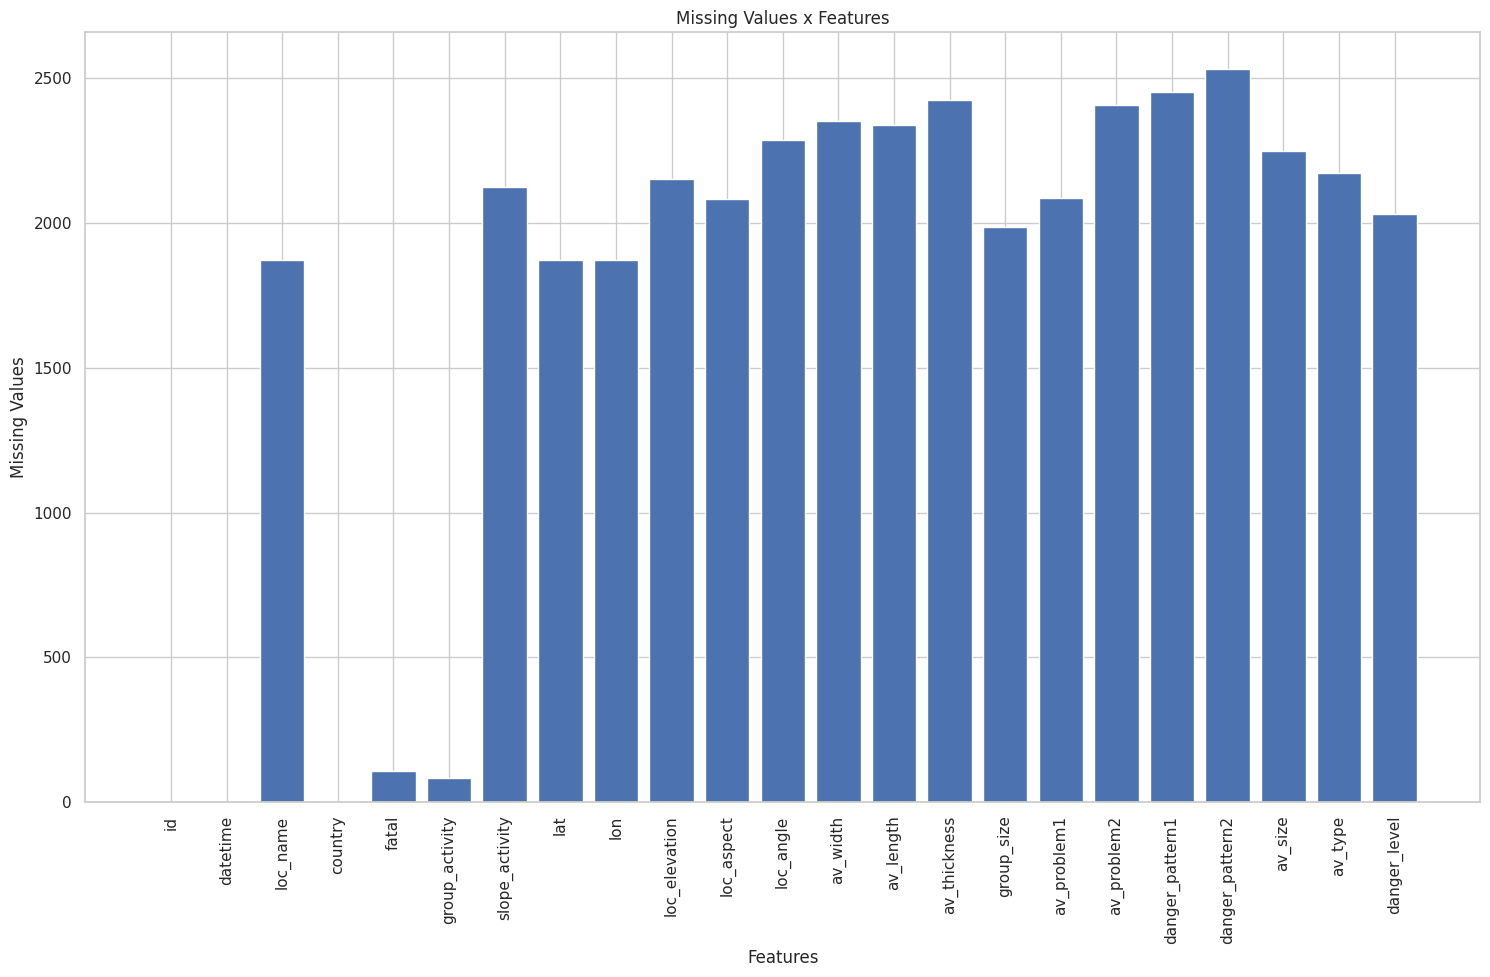

In [ ]:
# Ustawienie stylu wykresów
sns.set(style="whitegrid")

# Obliczenie liczby brakujących wartości dla każdej kolumny
missing_values = df.isna().sum()

# Wizualizacja brakujących wartości
plt.figure(figsize=(18,10))
plt.bar(range(len(missing_values)), missing_values)
plt.title('Missing Values x Features')
plt.xlabel('Features')
plt.ylabel('Missing Values')
plt.xticks(list(range(len(df.columns))), list(df.columns.values), rotation='vertical')
plt.show()

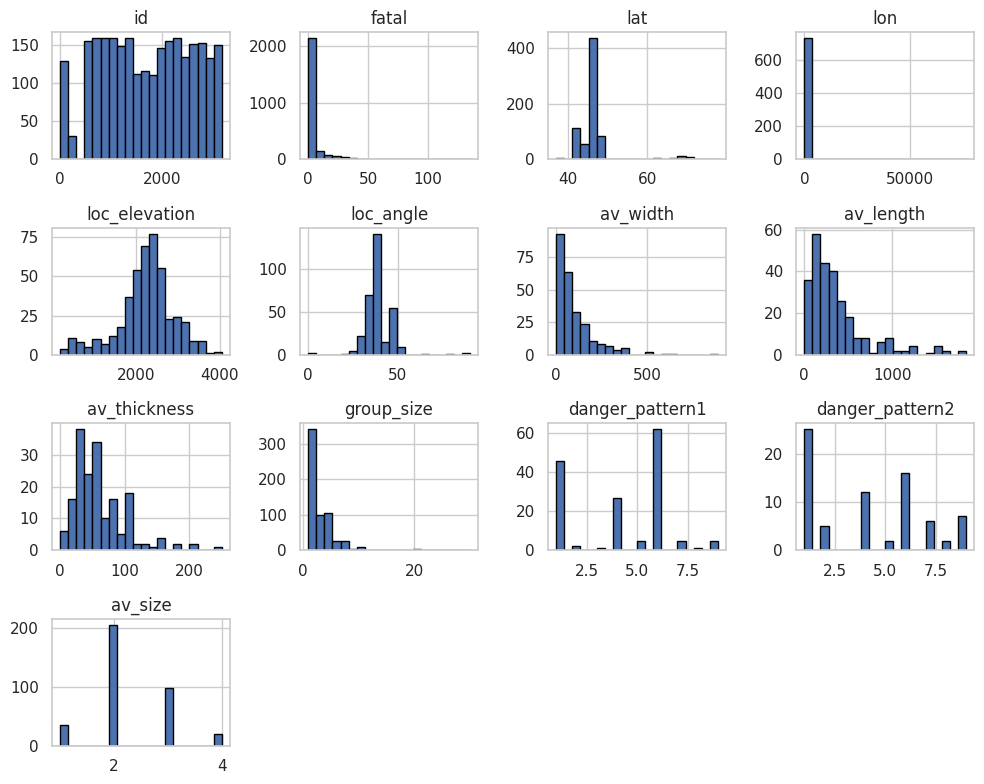

In [ ]:
# Histogram dla wszystkich kolumn numerycznych
df.hist(figsize=(10, 8), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

### Old data (2015-) analisys

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df_old = df[df['datetime'].dt.year < 1974]

df_old.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648 entries, 158 to 2494
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               648 non-null    int64         
 1   datetime         648 non-null    datetime64[ns]
 2   loc_name         6 non-null      object        
 3   country          648 non-null    object        
 4   fatal            647 non-null    float64       
 5   group_activity   648 non-null    object        
 6   slope_activity   4 non-null      object        
 7   lat              6 non-null      float64       
 8   lon              6 non-null      float64       
 9   loc_elevation    1 non-null      float64       
 10  loc_aspect       2 non-null      object        
 11  loc_angle        0 non-null      float64       
 12  av_width         0 non-null      float64       
 13  av_length        0 non-null      float64       
 14  av_thickness     0 non-null      float64    

In [ ]:
df_old[pd.notna(df_old['lat'])]

,id,datetime,loc_name,country,fatal,group_activity,slope_activity,lat,lon,loc_elevation,...,av_length,av_thickness,group_size,av_problem1,av_problem2,danger_pattern1,danger_pattern2,av_size,av_type,danger_level
1174,1553,1959-11-15 19:20:00,Monte della Neve,Italy,7.0,Unknown,NaN,46.504480,10.149902,2600.0,...,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339,2867,1704-04-17 00:00:00,Ceahlău Mt.,Romania,20.0,Other,NaN,47.262660,11.394540,NaN,...,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2343,2871,1936-03-15 15:00:00,Bucegi Mt,Romania,4.0,Mountaineering/Climbing,Descending,47.262660,11.394540,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,glide,NaN
2344,2872,1963-02-07 14:00:00,Făgăraș Mt,Romania,4.0,Mountaineering/Climbing,Traversing,47.262660,11.394540,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2446,2996,1971-01-31 14:20:00,Pala d´Eixe (estació esquí Espot),Spain,2.0,On skiruns,Descending,42.542365,1.062923,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,3.0,NaN,Region for which no avalanche bulletin exists
2494,3052,1972-12-29 12:00:00,Cabaña Verónica,Spain,0.0,Mountaineering/Climbing,Traversing,43.176130,-4.834180,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_mid = df[(df['datetime'].dt.year >= 1974) & (df['datetime'].dt.year <= 2014)]

df_mid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1244 entries, 165 to 2548
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               1244 non-null   int64         
 1   datetime         1244 non-null   datetime64[ns]
 2   loc_name         108 non-null    object        
 3   country          1243 non-null   object        
 4   fatal            1244 non-null   float64       
 5   group_activity   1242 non-null   object        
 6   slope_activity   87 non-null     object        
 7   lat              108 non-null    float64       
 8   lon              108 non-null    float64       
 9   loc_elevation    28 non-null     float64       
 10  loc_aspect       45 non-null     object        
 11  loc_angle        15 non-null     float64       
 12  av_width         20 non-null     float64       
 13  av_length        28 non-null     float64       
 14  av_thickness     1 non-null      float64   

In [ ]:
df['danger_level'].value_counts()

danger_level
3                                                299
2                                                159
4                                                 65
Region for which no avalanche bulletin exists     23
1                                                 19
Not rated at that time of the year                10
Name: count, dtype: int64

In [ ]:
# Convert 'danger_level' to numeric, coercing errors to NaN and then to None
df['danger_level'] = pd.to_numeric(df['danger_level'], errors='coerce')
df['danger_level'] = df['danger_level'].where(df['danger_level'].notna(), None)
df['danger_level'].value_counts()

danger_level
3.0    299
2.0    159
4.0     65
1.0     19
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2606 entries, 0 to 2605
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               2606 non-null   int64         
 1   datetime         2606 non-null   datetime64[ns]
 2   loc_name         734 non-null    object        
 3   country          2601 non-null   object        
 4   fatal            2497 non-null   float64       
 5   group_activity   2524 non-null   object        
 6   slope_activity   481 non-null    object        
 7   lat              734 non-null    float64       
 8   lon              734 non-null    float64       
 9   loc_elevation    456 non-null    float64       
 10  loc_aspect       524 non-null    object        
 11  loc_angle        322 non-null    float64       
 12  av_width         254 non-null    float64       
 13  av_length        270 non-null    float64       
 14  av_thickness     181 non-null    float64

In [ ]:
df['loc_aspect'].value_counts()

loc_aspect
N     103
NE     99
E      64
SE     64
NW     64
S      55
W      39
SW     36
Name: count, dtype: int64

## Newest data analisys (2016+)

There are records with missing position. Since we can't fetch weather data without coordinates, we will drop them.

In [ ]:
def getAvalanchesData(file_path, start_year):
    df = pd.read_csv(file_path, delimiter=';')      # read from file
    df['datetime'] = pd.to_datetime(df['datetime'])     # convert data
    df['danger_level'] = pd.to_numeric(df['danger_level'], errors='coerce')    # convert data
    df['danger_level'] = df['danger_level'].where(df['danger_level'].notna(), None) # convert data
    dfn = df[(df['datetime'].dt.year >= start_year)]               # select data after 2015
    dfn = dfn[dfn['lon'] <= 180]            # drop invalid rows
    dfn = dfn[dfn['lat'].notna()].reset_index(drop=True)    # drop records with missing position
    return dfn


df_newest = getAvalanchesData('drive/MyDrive/Colab/eaws.csv', 2016)
df_newest.shape

(616, 23)

In [ ]:
# Wybór tylko kolumn numerycznych
numeric_df = df_newest.select_dtypes(include=[np.number])

# Wyświetlenie pierwszych kilku wierszy kolumn numerycznych
numeric_df.head()

,id,fatal,lat,lon,loc_elevation,loc_angle,av_width,av_length,av_thickness,group_size,danger_pattern1,danger_pattern2,av_size,danger_level
0,3,2.0,46.935601,10.937191,2850.0,40.0,100.0,300.0,60.0,3.0,1.0,6.0,2.0,NaN
1,4,1.0,47.120100,10.314100,2450.0,43.0,100.0,1050.0,100.0,4.0,7.0,NaN,3.0,2.0
2,6,1.0,47.025348,11.036651,3020.0,40.0,70.0,400.0,60.0,8.0,4.0,7.0,2.0,2.0
3,19,NaN,47.027993,12.415425,2450.0,40.0,400.0,500.0,NaN,NaN,2.0,NaN,4.0,4.0
4,20,NaN,46.987867,12.608574,2500.0,45.0,NaN,1200.0,100.0,NaN,6.0,NaN,4.0,4.0


In [ ]:
# Podstawowe statystyki opisowe dla kolumn numerycznych
numeric_df.describe()

,id,fatal,lat,lon,loc_elevation,loc_angle,av_width,av_length,av_thickness,group_size,danger_pattern1,danger_pattern2,av_size,danger_level
count,616.000000,509.000000,616.000000,616.000000,426.000000,306.000000,233.000000,242.000000,179.000000,516.000000,154.000000,75.000000,337.000000,518.000000
mean,1911.699675,1.174853,47.634995,10.512710,2243.063380,39.349673,99.145923,357.487603,60.117318,2.906977,4.194805,4.133333,2.264095,2.752896
std,1134.606991,0.770313,5.234651,4.732509,681.319114,7.308559,117.982557,343.218199,39.976295,2.567737,2.365542,2.776997,0.710247,0.709661
min,3.000000,0.000000,41.815582,-21.547022,200.000000,0.000000,0.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,193.500000,1.000000,45.900563,7.592293,1900.000000,35.000000,30.000000,132.500000,35.000000,1.000000,1.000000,1.000000,2.000000,2.000000
50%,2130.500000,1.000000,46.675818,10.567208,2300.000000,40.000000,60.000000,250.000000,50.000000,2.000000,5.000000,4.000000,2.000000,3.000000
75%,2877.250000,1.000000,47.128850,12.024637,2617.500000,41.750000,122.000000,433.750000,80.000000,4.000000,6.000000,6.000000,3.000000,3.000000
max,3165.000000,6.000000,77.867274,26.583223,4050.000000,90.000000,890.000000,1833.000000,250.000000,30.000000,9.000000,9.000000,4.000000,4.000000


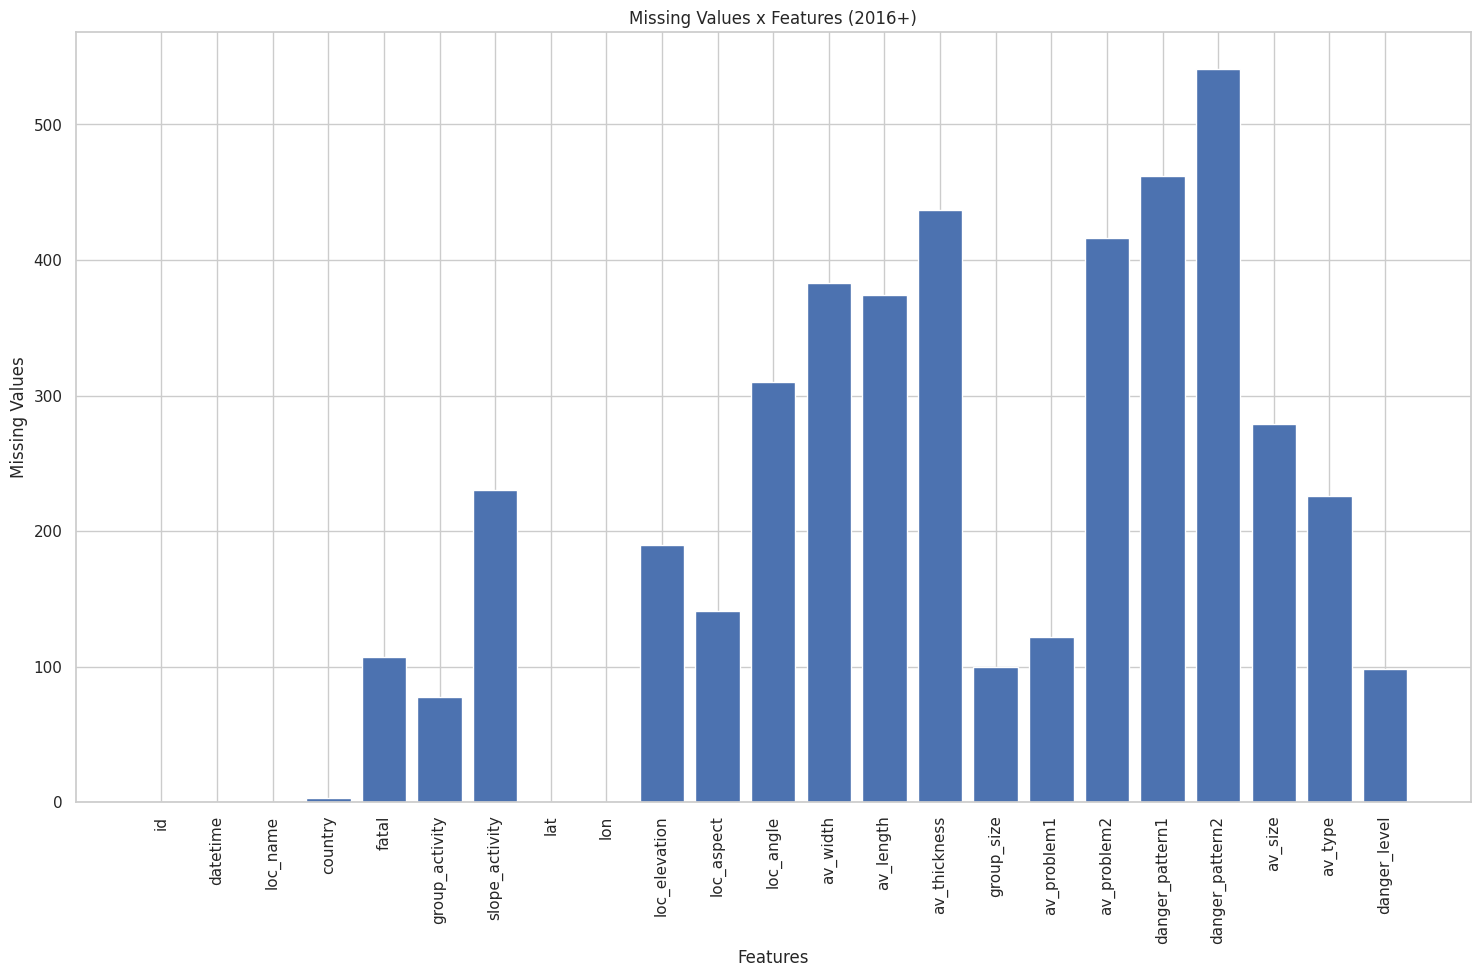

In [ ]:
# Obliczenie liczby brakujących wartości dla każdej kolumny
missing_values = df_newest.isna().sum()

# Wizualizacja brakujących wartości
plt.figure(figsize=(18,10))
plt.bar(range(len(missing_values)), missing_values)
plt.title('Missing Values x Features (2016+)')
plt.xlabel('Features')
plt.ylabel('Missing Values')
plt.xticks(list(range(len(df_newest.columns))), list(df_newest.columns.values), rotation='vertical')
plt.show()

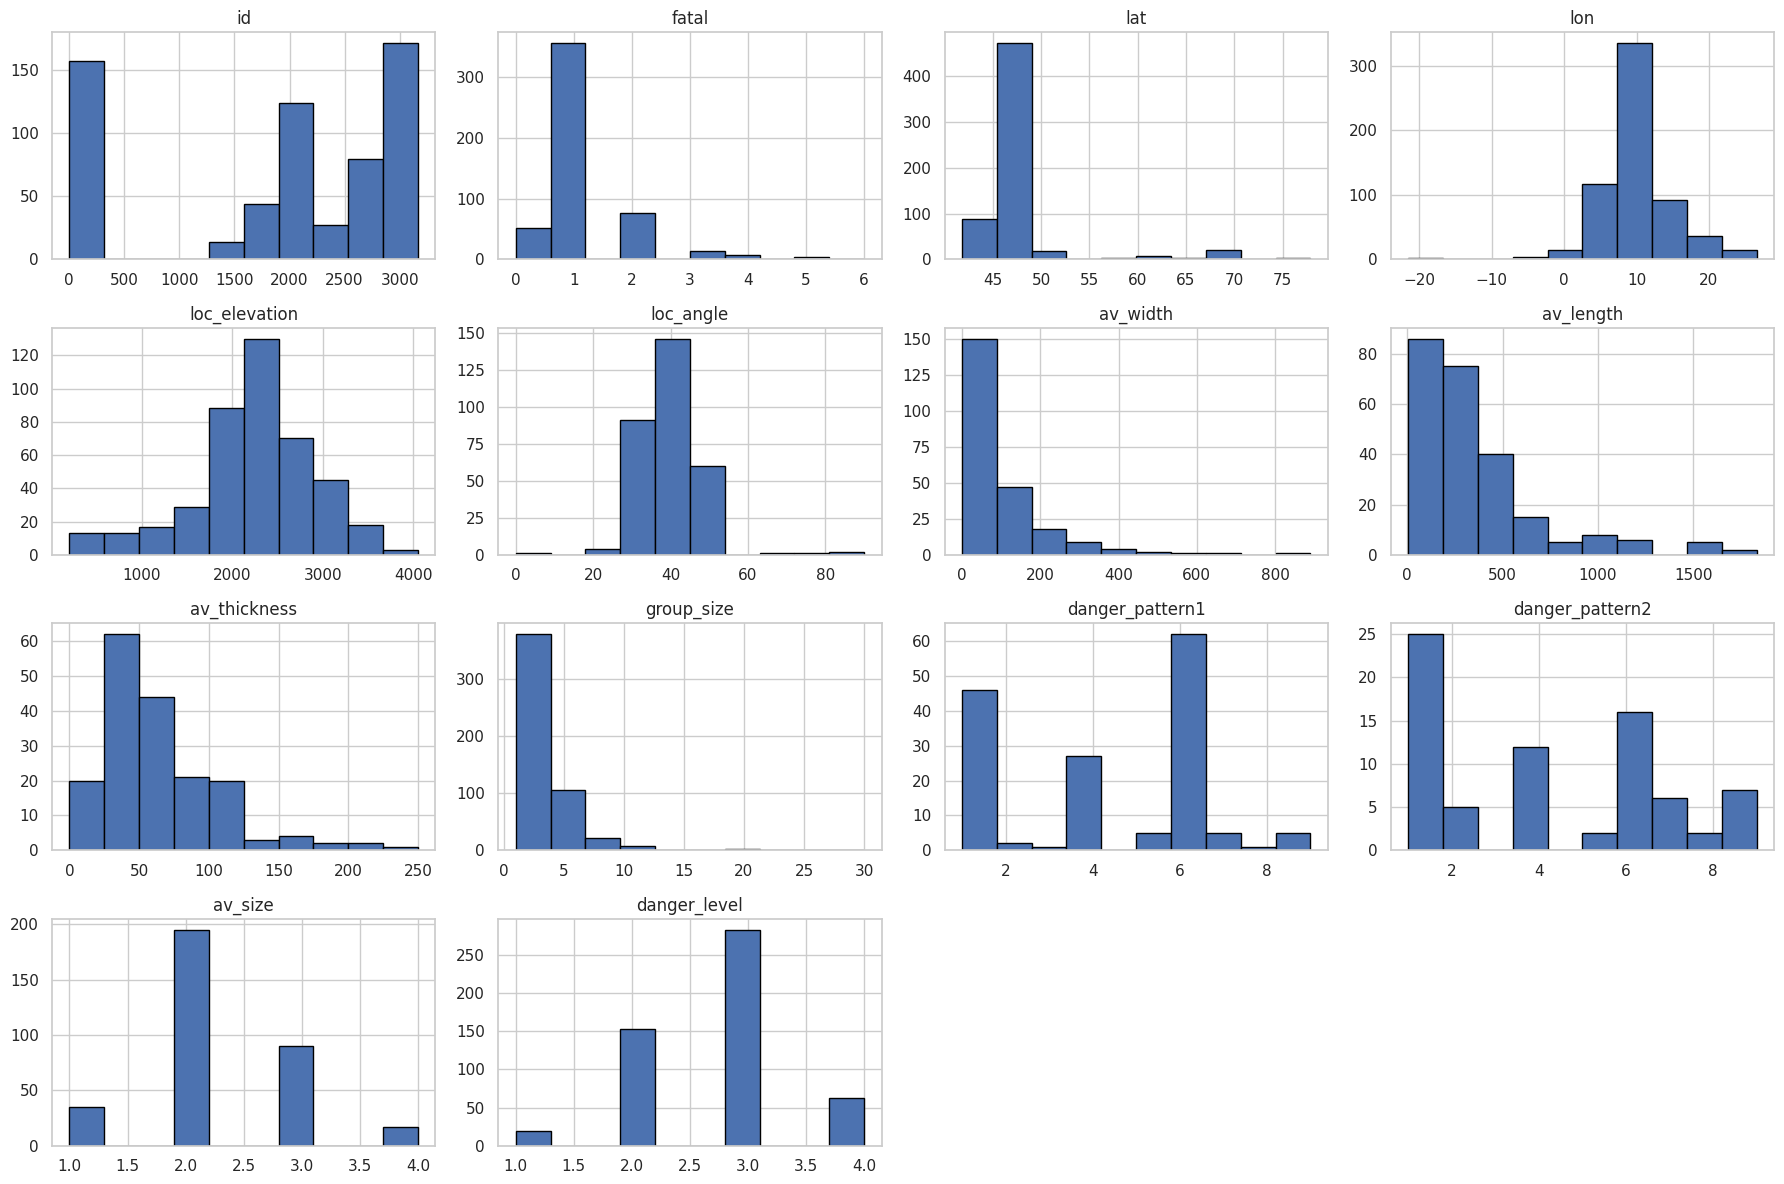

In [ ]:
sns.set(style="whitegrid")

# Histogram dla wszystkich kolumn numerycznych
numeric_df.hist(figsize=(18, 12), bins=10, edgecolor='black')
plt.tight_layout()
plt.show()

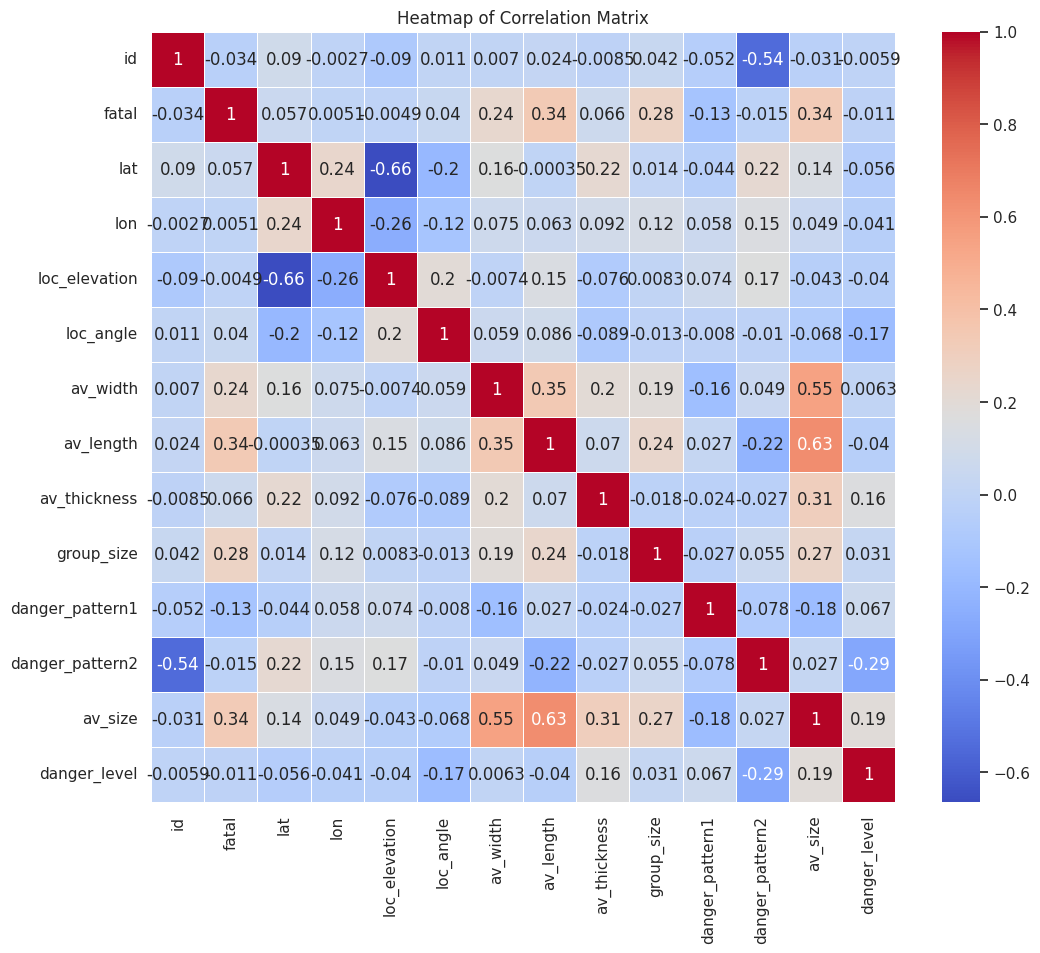

In [ ]:
# Macierz korelacji
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

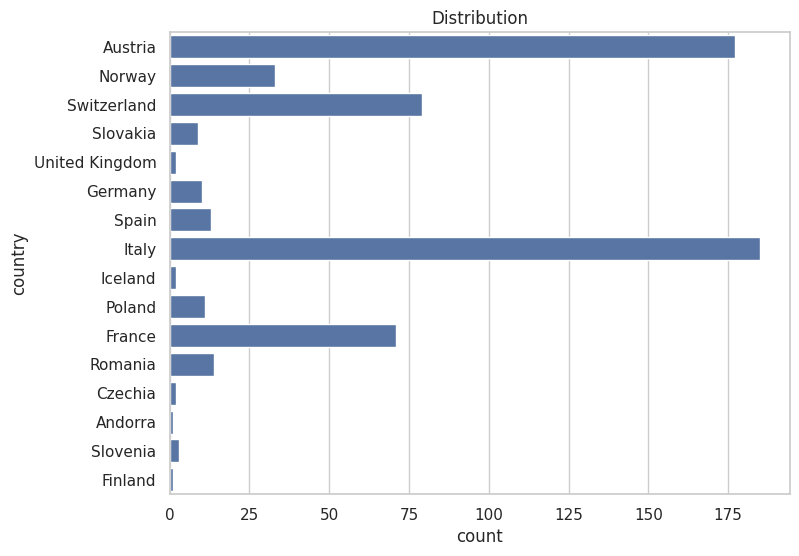

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(df_newest['country'])
plt.title('Distribution')
plt.show()

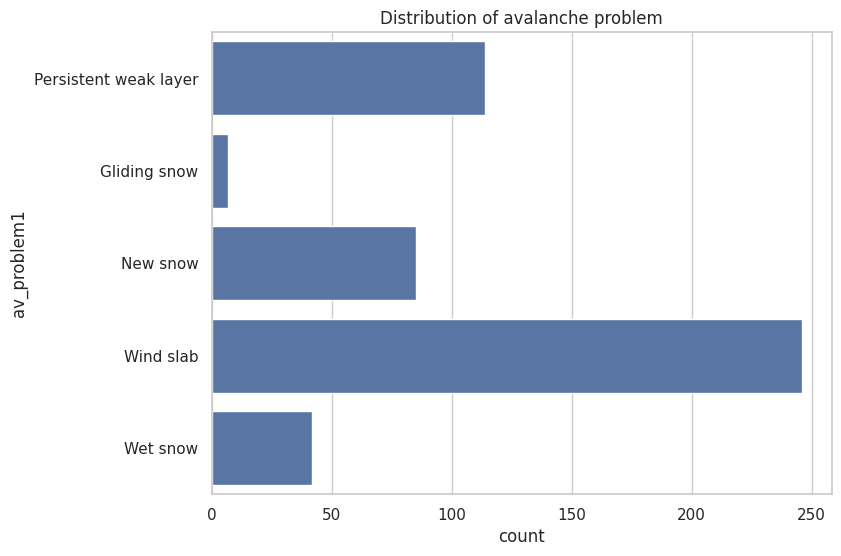

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(df_newest['av_problem1'])
plt.title('Distribution of avalanche problem')
plt.show()

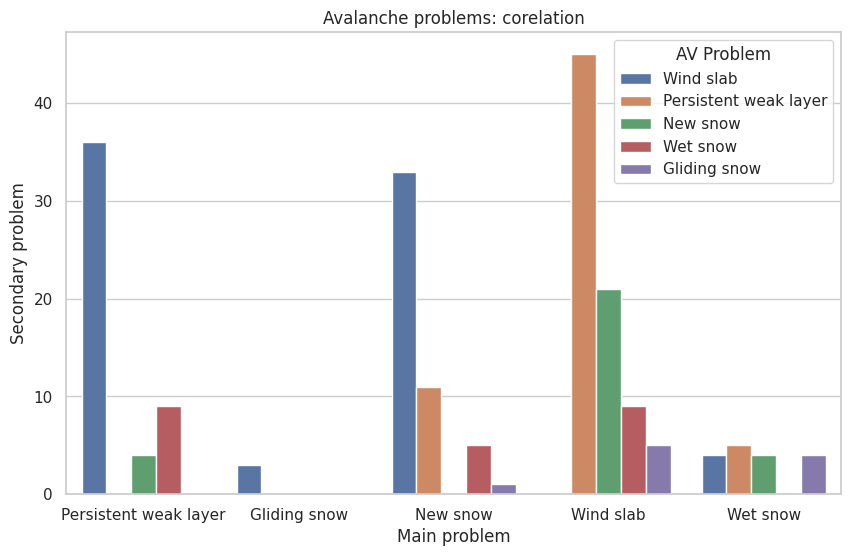

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_newest, x='av_problem1', hue='av_problem2')
plt.title('Avalanche problems: corelation')
plt.xlabel('Main problem')
plt.ylabel('Secondary problem')
plt.legend(title='AV Problem')
plt.show()

### Danger Patterns

#### [GOPR info](https://www.gopr.pl/en/avalanches/danger-patterns)

1. **Danger Pattern 1 – The Second Snowfall**  
   Slab avalanches, which cause most fatalities, often occur after the second snowfall, especially on steep, shady slopes above 2000m.

2. **Danger Pattern 2 – Sliding Snow**  
   Full depth snowslides can occur anytime on steep, smooth slopes, marked by glide cracks, and are difficult to predict.

3. **Danger Pattern 3 - Rain**  
   Rain adds weight and reduces snowpack firmness, often triggering avalanches. It is easy to recognize and can happen any time in winter.

4. **Danger Pattern 4 – Temperature Change**  
   Big temperature changes during snowfall can weaken the snowpack, forming weak layers prone to triggering, particularly on south-facing slopes.

5. **Danger Pattern 5 – Snowfall After Cold Period**  
   Fresh snow or strong winds after a long cold period can create a dangerous situation, with poorly bonded snow layers ready to be triggered.

6. **Danger Pattern 6 – Cold, Loose Snow and Wind**  
   Wind transports loose, cold snow, increasing avalanche danger. This pattern is easy to spot and occurs when wind follows low-temperature snowfall.

7. **Danger Pattern 7 – Snow-Poor Zones in Snow-Rich Winters**  
   In snow-rich winters, avalanches are more likely in wind-exposed, snow-poor areas due to less favorable snow layering.

8. **Danger Pattern 8 – Surface Hoar Blanketed with Snow**  
   Surface hoar is harmless until covered by new snow, then it becomes a critical weak layer, increasing avalanche risk.

9. **Danger Pattern 9 – Graupel Blanketed with Snow**  
   Graupel, a ball-shaped precipitation, creates weak layers that escalate avalanche danger, although it usually causes short-term problems.

10. **Danger Pattern 10 – Springtime Situation**  
    Spring presents challenges with fluctuating danger levels. Stable firn snow can quickly become hazardous due to temperature, humidity, solar radiation, and wind. Planning and timing are crucial.


In [ ]:
# Grouping by 'danger_pattern1' and summing 'fatal' values
grouped_df1 = numeric_df.groupby('danger_pattern1')['fatal'].sum().reset_index()
# Grouping by 'danger_pattern2' and summing 'fatal' values
grouped_df2 = numeric_df.groupby('danger_pattern2')['fatal'].sum().reset_index()

<ipython-input-48-3cd101f4e0ba>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summed_heights, x=summed_heights.index + 1, y='total_fatalities', palette='Set1')


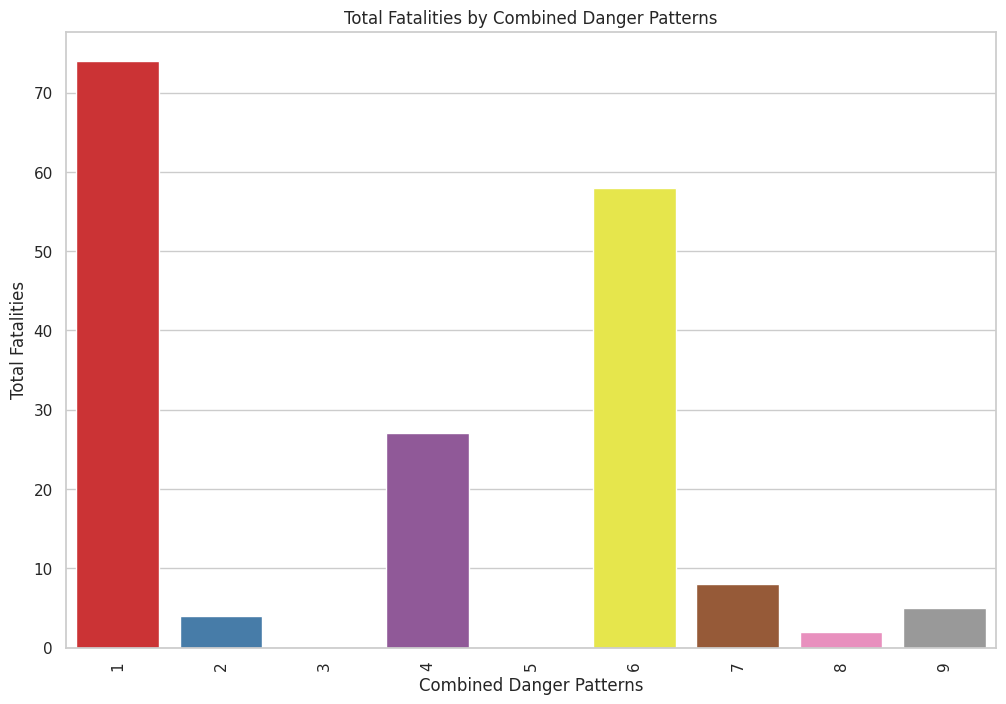

In [ ]:
# Summing the heights of bars from plot1 and plot2
summed_heights = grouped_df1.set_index('danger_pattern1')['fatal'] + grouped_df2.set_index('danger_pattern2')['fatal']
summed_heights = summed_heights.reset_index(name='total_fatalities')

# Ustawienie rozmiaru wykresu
plt.figure(figsize=(12, 8))

# Wykres słupkowy dla sumy wysokości słupków z plot1 i plot2
sns.barplot(data=summed_heights, x=summed_heights.index + 1, y='total_fatalities', palette='Set1')

# Dodanie tytułu i etykiet osi
plt.title('Total Fatalities by Combined Danger Patterns')
plt.xlabel('Combined Danger Patterns')
plt.ylabel('Total Fatalities')

# Pokazanie wykresu
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


### Avalanche problems

#### [EAWS avalanche problems](https://www.avalanches.org/wp-content/uploads/2022/09/EN_EAWS_avalanche_problems.pdf)



# Weather data

## open-meteo API

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 49.232,
	"longitude": 19.982,
	"start_date": "2024-02-01",
	"end_date": "2024-02-14",
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "snow_depth", "cloud_cover", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
	"daily": ["temperature_2m_mean", "apparent_temperature_max", "sunshine_duration", "precipitation_sum", "precipitation_hours", "wind_speed_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum"],
	"wind_speed_unit": "ms",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

In [ ]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(8).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe

Coordinates 49.244285583496094°N 20.03424644470215°E
Elevation 1977.0 m asl
Timezone b'Europe/Warsaw' b'CEST'
Timezone difference to GMT+0 7200 s


,date,temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2024-01-31 22:00:00+00:00,-4.562000,83.309662,0.0,0.0,0.88,56.699997,1.562050,230.194473,6.5
1,2024-01-31 23:00:00+00:00,-3.962000,84.670364,0.0,0.0,0.88,85.500000,1.526434,211.607452,6.4
2,2024-02-01 00:00:00+00:00,-4.512000,87.905388,0.0,0.0,0.88,90.000000,1.581139,214.695221,6.3
3,2024-02-01 01:00:00+00:00,-5.412000,90.907623,0.0,0.0,0.88,92.099998,2.420744,218.290207,8.6
4,2024-02-01 02:00:00+00:00,-6.562000,89.080254,0.0,0.0,0.88,81.900002,2.385372,213.023865,8.4
...,...,...,...,...,...,...,...,...,...,...
331,2024-02-14 17:00:00+00:00,-9.412001,83.002357,0.0,0.0,0.69,11.400000,0.948683,161.564957,2.8
332,2024-02-14 18:00:00+00:00,-10.212000,83.566307,0.0,0.0,0.69,9.600000,1.019804,168.690109,3.1
333,2024-02-14 19:00:00+00:00,-5.812000,59.646130,0.0,0.0,0.69,11.400001,1.303840,184.398621,3.5
334,2024-02-14 20:00:00+00:00,-4.362000,56.539276,0.0,0.0,0.69,26.700001,1.664332,212.735214,4.3


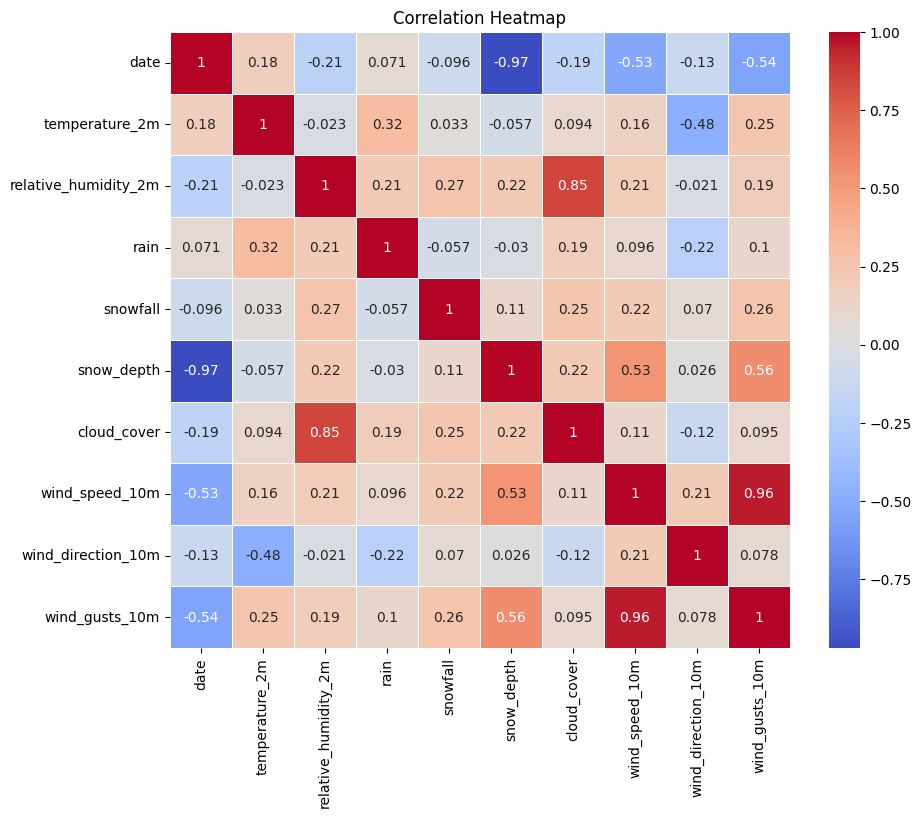

In [ ]:
# Calculate the correlation matrix
corr_matrix = hourly_dataframe.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(1).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(2).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(3).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(4).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(6).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(7).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
daily_dataframe

,date,temperature_2m_mean,apparent_temperature_max,sunshine_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum
0,2024-01-31 22:00:00+00:00,-5.876583,-7.671039,1303.306152,1.300000,7.0,5.798275,276.064819,2.84
1,2024-02-01 22:00:00+00:00,-9.243249,-12.359703,11126.316406,2.400000,14.0,6.296825,297.572754,4.28
2,2024-02-02 22:00:00+00:00,-4.232833,-8.322881,822.239441,2.000000,15.0,6.700747,300.839508,2.56
3,2024-02-03 22:00:00+00:00,-4.107833,-8.071752,12010.161133,14.500000,24.0,7.244998,288.666443,4.24
4,2024-02-04 22:00:00+00:00,-3.374500,-8.391283,0.000000,22.600002,20.0,7.602631,288.940094,1.66
5,2024-02-05 22:00:00+00:00,-2.724500,-6.289884,29667.732422,0.000000,0.0,7.569016,268.368347,8.84
6,2024-02-06 22:00:00+00:00,-4.351584,-8.181864,1116.536255,7.700000,17.0,6.198387,247.024231,3.36
7,2024-02-07 22:00:00+00:00,-3.766166,-6.740160,1936.359009,13.700002,23.0,5.382379,230.589890,3.52
8,2024-02-08 22:00:00+00:00,-1.037000,-2.975167,10516.520508,2.500000,9.0,6.105735,219.460938,5.51
9,2024-02-09 22:00:00+00:00,-1.434917,-4.379104,8005.805664,3.900000,13.0,5.434152,191.350311,4.88


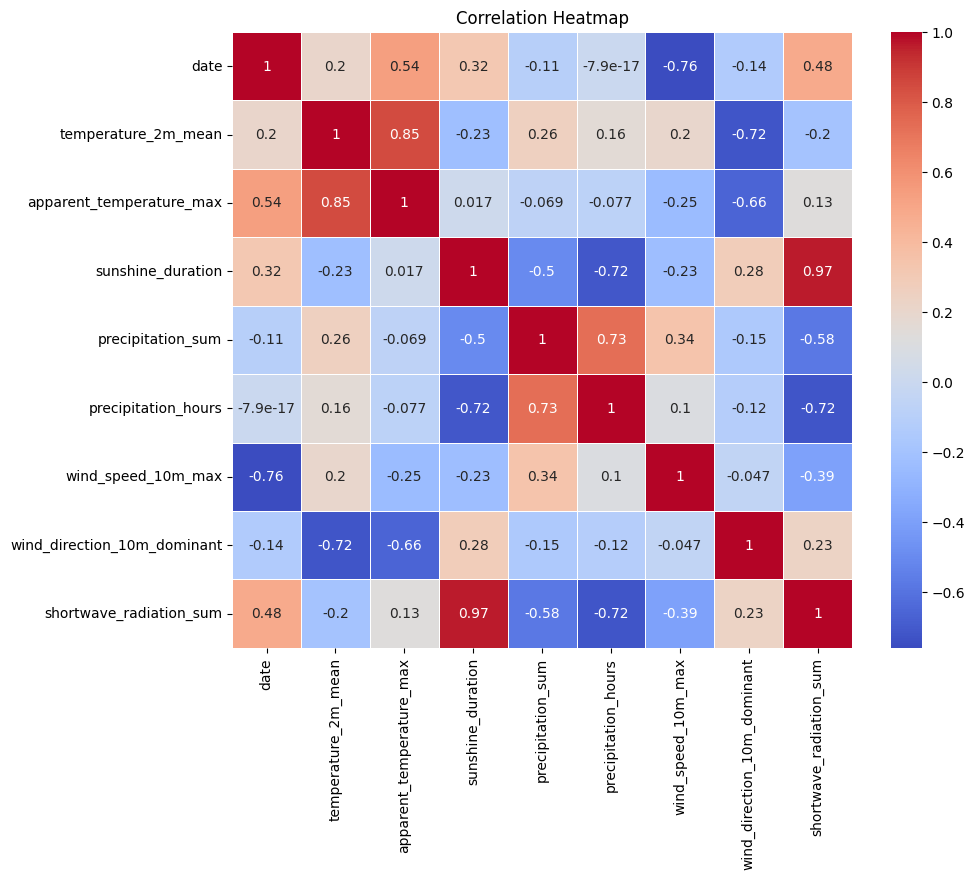

In [ ]:
# Calculate the correlation matrix
corr_matrix = daily_dataframe.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 49.232,
	"longitude": 19.982,
	"start_date": "2024-02-01",
	"end_date": "2024-02-21",
	"daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum"],
	"wind_speed_unit": "ms",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(2).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(3).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
daily_dataframe

Coordinates 49.244285583496094°N 20.03424644470215°E
Elevation 1977.0 m asl
Timezone b'Europe/Warsaw' b'CEST'
Timezone difference to GMT+0 7200 s


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum
0,2024-01-31 22:00:00+00:00,-5.876583,1.300000,5.798275,276.064819,2.84
1,2024-02-01 22:00:00+00:00,-9.243249,2.400000,6.296825,297.572754,4.28
2,2024-02-02 22:00:00+00:00,-4.232833,2.000000,6.700747,300.839508,2.56
3,2024-02-03 22:00:00+00:00,-4.107833,14.500000,7.244998,288.666443,4.24
4,2024-02-04 22:00:00+00:00,-3.374500,22.600002,7.602631,288.940094,1.66
5,2024-02-05 22:00:00+00:00,-2.724500,0.000000,7.569016,268.368347,8.84
6,2024-02-06 22:00:00+00:00,-4.351584,7.700000,6.198387,247.024231,3.36
7,2024-02-07 22:00:00+00:00,-3.766166,13.700002,5.382379,230.589890,3.52
8,2024-02-08 22:00:00+00:00,-1.037000,2.500000,6.105735,219.460938,5.51
9,2024-02-09 22:00:00+00:00,-1.434917,3.900000,5.434152,191.350311,4.88


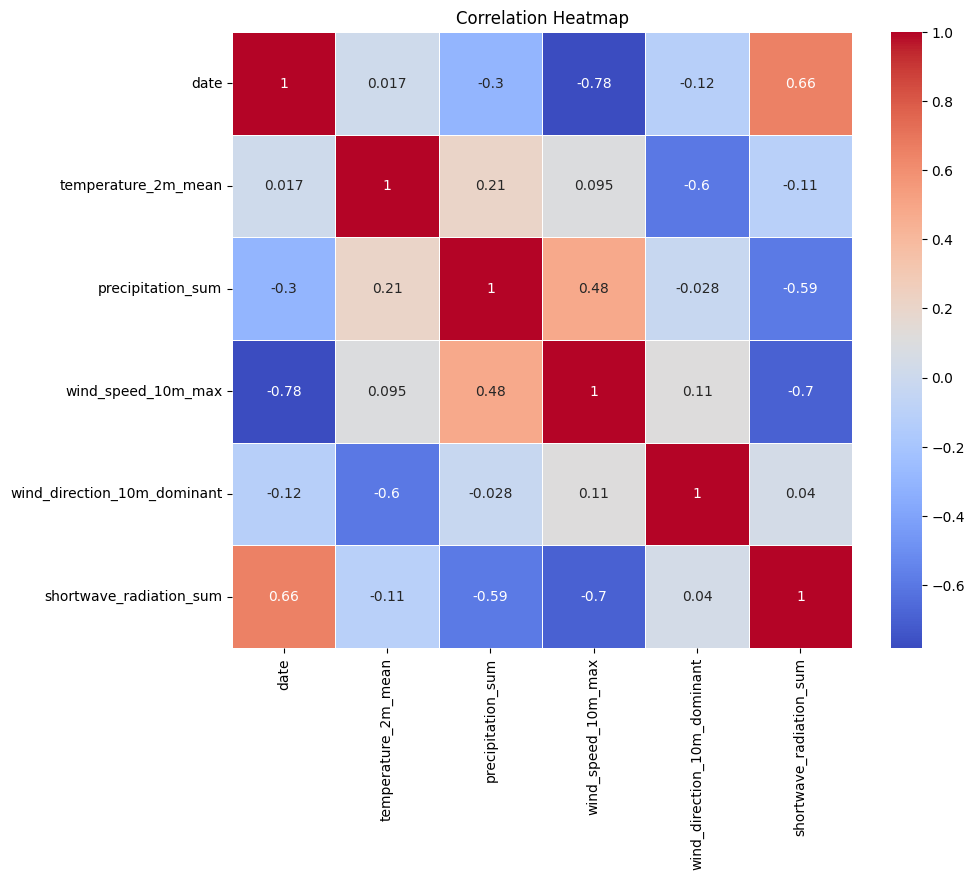

In [ ]:
# Calculate the correlation matrix
corr_matrix = daily_dataframe.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## WEATHER FUNCTIONS

In [ ]:
# Define helper function to get weather data for specified location and time
url_api = "https://archive-api.open-meteo.com/v1/archive"
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def getWeatherData(lat, lon, start_date, end_date, loud=False):
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date, # date format: "2024-02-01"
        "end_date": end_date,
        "daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum"],
        "wind_speed_unit": "ms",
        "timezone": "auto"
    }
    responses = openmeteo.weather_api(url_api, params=params)
    response = responses[0]
    response_info = [f"Coordinates {response.Latitude()}°N {response.Longitude()}°E", f"Elevation {response.Elevation()} m asl", f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}"]
    if loud:
        print(response_info)
    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(2).ValuesAsNumpy()
    daily_wind_direction_10m_dominant = daily.Variables(3).ValuesAsNumpy()
    daily_shortwave_radiation_sum = daily.Variables(4).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
    daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

    daily_dataframe = pd.DataFrame(data = daily_data)
    return daily_dataframe

In [ ]:
def replace_with_means(df, nrows, loud=True):
    # print(f"Converting {df.shape[0]} rows into {df.shape[0]-sum(nrows)+len(nrows)}, applying mean {len(nrows)} times")
    means = pd.DataFrame()
    for i, n in enumerate(nrows):
        means = pd.concat([means, df.iloc[-n:].mean().to_frame().T], ignore_index=True)  # extract mean from last n-rows
        df = df.iloc[:-n]           # drop last n-rows
    means = means.iloc[::-1]        # reverse means dataframe (as we were adding means from the end)
    df = pd.concat([df, means], ignore_index=True)  # concat means and the rest of df
    return df

def renameColumns(data):
    new_column_names = {
        'date': 'date',
        'temperature_2m_mean': 'temp',
        'precipitation_sum': 'prec',
        'wind_speed_10m_max': 'wind_speed',
        'wind_direction_10m_dominant': 'wind_dir',
        'shortwave_radiation_sum': 'srs'
    }
    return data.rename(columns=new_column_names)

def revertDates(data, drop=False):
    data = data.sort_values(by="date", ascending=False)     # Revert dates (index as accident's date-n)
    data = data.reset_index(drop=True)
    if drop:
        data = data.drop(columns=["date"])
    return data

def convertWind(data, drop=True):
    # Convert wind direction to sin & cos components
    data['wind_dir_rad'] = np.deg2rad(data['wind_dir'])
    data['wind_sin'] = np.sin(data['wind_dir_rad'])
    data['wind_cos'] = np.cos(data['wind_dir_rad'])
    if drop:
        return data.drop(columns=['wind_dir_rad', 'wind_dir'])
    return data.drop(columns=['wind_dir_rad'])


def processDailyDataframe(daily_data, drop_dates=False):
    result = renameColumns(daily_data)
    result = revertDates(result, drop_dates)
    result = convertWind(result)
    return result

In [ ]:
def getAvalanchesData(file_path, start_year):
    df = pd.read_csv(file_path, delimiter=';')      # read from file
    df['datetime'] = pd.to_datetime(df['datetime'])     # convert data
    df['danger_level'] = pd.to_numeric(df['danger_level'], errors='coerce')    # convert data
    df['danger_level'] = df['danger_level'].where(df['danger_level'].notna(), None) # convert data
    dfn = df[(df['datetime'].dt.year >= start_year)]               # select data after 2015
    dfn = dfn[dfn['lon'] <= 180]            # drop invalid rows
    dfn = dfn[dfn['lat'].notna()].reset_index(drop=True)    # drop records with missing position
    return dfn

## Process weather data
Sandbox



In [ ]:
wdata = getWeatherData(lat=49.232, lon=19.982, start_date="2023-12-30", end_date="2024-01-12")
wdata.head()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum
0,2023-12-29 22:00:00+00:00,-3.572417,0.000000,5.243091,244.315186,3.26
1,2023-12-30 22:00:00+00:00,-4.012000,2.500000,4.609772,204.512970,2.86
2,2023-12-31 22:00:00+00:00,-4.770333,14.200000,5.608030,262.720703,0.93
3,2024-01-01 22:00:00+00:00,-6.762000,3.300000,4.785394,218.846893,3.16
4,2024-01-02 22:00:00+00:00,-3.680751,5.899999,6.774216,236.851212,2.19


In [ ]:
# Rename columns
new_column_names = {
    'date': 'date',
    'temperature_2m_mean': 'temp',
    'precipitation_sum': 'prec',
    'wind_speed_10m_max': 'wind_speed',
    'wind_direction_10m_dominant': 'wind_dir',
    'shortwave_radiation_sum': 'srs'
}
wdata = wdata.rename(columns=new_column_names)

In [ ]:
# Revert dates (index as accident's date - x)
wdata = wdata.sort_values(by="date", ascending=False)
wdata = wdata.reset_index(drop=True)
wdata = wdata.drop(columns=["date"])
wdata.head()

,temp,prec,wind_speed,wind_dir,srs
0,-15.276584,3.1,3.765634,331.968933,3.80
1,-8.353667,2.5,3.400000,297.485870,4.25
2,-6.120333,0.0,1.838478,185.740494,6.16
3,-13.680751,0.0,3.138471,118.072426,6.16
4,-16.028667,0.8,3.894868,51.740993,4.59


In [ ]:
# Convert wind direction to sin & cos components
wdata['wind_dir_rad'] = np.deg2rad(wdata['wind_dir'])
wdata['wind_sin'] = np.sin(wdata['wind_dir_rad'])
wdata['wind_cos'] = np.cos(wdata['wind_dir_rad'])
wdata = wdata.drop(columns=['wind_dir_rad', 'wind_dir'])
wdata.head()

,temp,prec,wind_speed,srs,wind_sin,wind_cos
0,-15.276584,3.1,3.765634,3.80,-0.469950,0.882693
1,-8.353667,2.5,3.400000,4.25,-0.887125,0.461530
2,-6.120333,0.0,1.838478,6.16,-0.100023,-0.994985
3,-13.680751,0.0,3.138471,6.16,0.882353,-0.470587
4,-16.028667,0.8,3.894868,4.59,0.785220,0.619217


In [ ]:
wdata

,temp,prec,wind_speed,srs,wind_sin,wind_cos
0,-15.276584,3.100000,3.765634,3.80,-0.469950,0.882693
1,-8.353667,2.500000,3.400000,4.25,-0.887125,0.461530
2,-6.120333,0.000000,1.838478,6.16,-0.100023,-0.994985
3,-13.680751,0.000000,3.138471,6.16,0.882353,-0.470587
4,-16.028667,0.800000,3.894868,4.59,0.785220,0.619217
5,-10.826584,7.900000,2.906888,1.21,0.735356,0.677681
6,-2.487000,9.300000,4.341659,1.31,-0.012657,-0.999920
7,-5.282833,0.600000,6.640783,4.53,-0.899918,-0.436060
8,-4.503666,5.999999,7.072482,1.92,-0.953418,-0.301653
9,-3.680751,5.899999,6.774216,2.19,-0.837253,-0.546815


In [ ]:
wdata_r = wdata
wdata_r = replace_with_means(wdata_r, [6, 3, 2, 1, 1, 1])
wdata_r

Converting 14 rows into 6, applying mean 6 times


,temp,prec,wind_speed,srs,wind_sin,wind_cos
0,-15.276584,3.100000,3.765634,3.800000,-0.469950,0.882693
1,-8.353667,2.500000,3.400000,4.250000,-0.887125,0.461530
2,-6.120333,0.000000,1.838478,6.160000,-0.100023,-0.994985
3,-14.854710,0.400000,3.516670,5.375000,0.833786,0.074315
4,-6.198805,5.933334,4.629776,2.350000,-0.059073,-0.252766
5,-4.550194,5.316666,5.682165,2.386667,-0.787657,-0.516214


## Fetch weather for avalanche accidents

In [ ]:
file_path = 'drive/MyDrive/Colab/eaws.csv'
dfa = getAvalanchesData(file_path, 2016)
dfa.shape

(616, 23)

In [ ]:
# DAYS_BEFORE = 13
# SEQUENCE = [6, 3, 2, 1, 1, 1]
# dfa_coords = dfa[['datetime', 'lat', 'lon']]
# weather_data = []

# for idx, row in dfa_coords.iterrows():
#     date_event = row['datetime'].date()
#     date_start = date_event - timedelta(days=DAYS_BEFORE)
#     lat = row['lat']
#     lon = row['lon']
#     wdata = getWeatherData(lat=lat, lon=lon, start_date=date_start, end_date=date_event)
#     pdata = processDailyDataframe(wdata, True)
#     rdata = replace_with_means(pdata, SEQUENCE)
#     weather_data.append(rdata)

# if len(weather_data) != len(dfa):
#     print("Missing data!")
# len(weather_data)

In [ ]:
weather_fp = 'drive/MyDrive/Colab/weather_dfs.pkl'
# Save array of DataFrames to a pickle file
# with open(weather_fp, 'wb') as f:
#     pickle.dump(weather_data, f)

# Load array of DataFrames from a pickle file
with open(weather_fp, 'rb') as f:
    loaded_dfs = pickle.load(f)

len(loaded_dfs)

616

## Analize data

array([[<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'prec'}>],
       [<Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'srs'}>],
       [<Axes: title={'center': 'wind_sin'}>,
        <Axes: title={'center': 'wind_cos'}>]], dtype=object)

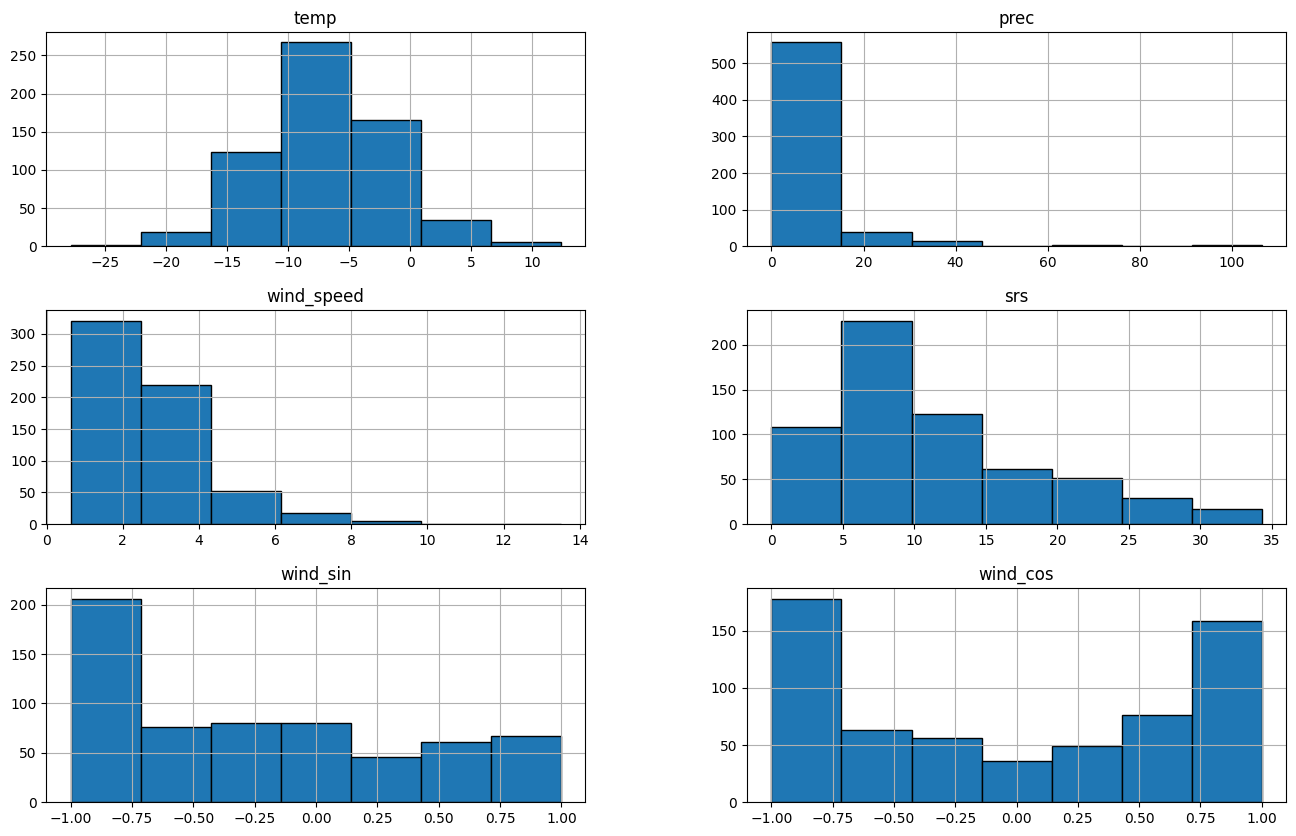

In [ ]:
first_rows = [df.iloc[0] for df in loaded_dfs]

# Concatenate these rows into a single DataFrame
accidents_day = pd.DataFrame(first_rows).reset_index(drop=True)
accidents_day.hist(figsize=(16, 10), bins=7, edgecolor='black')

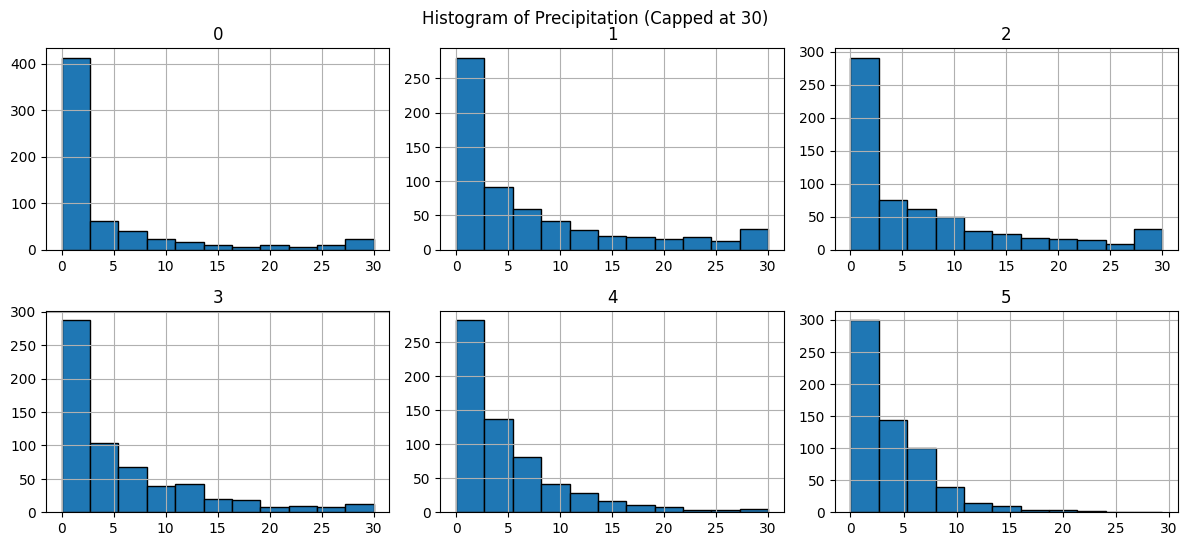

In [ ]:
prec_rows = [df.iloc[:, 1] for df in loaded_dfs]
prec_info = pd.DataFrame(prec_rows).reset_index(drop=True)
prec_info = prec_info.applymap(lambda x: min(x, 30))    # trim at 30

# Plot the histogram
prec_info.hist(figsize=(12, 16), bins=11, edgecolor='black', layout=(prec_info.shape[1], 3))
plt.suptitle('Histogram of Precipitation (Capped at 30)')
plt.tight_layout()
plt.show()

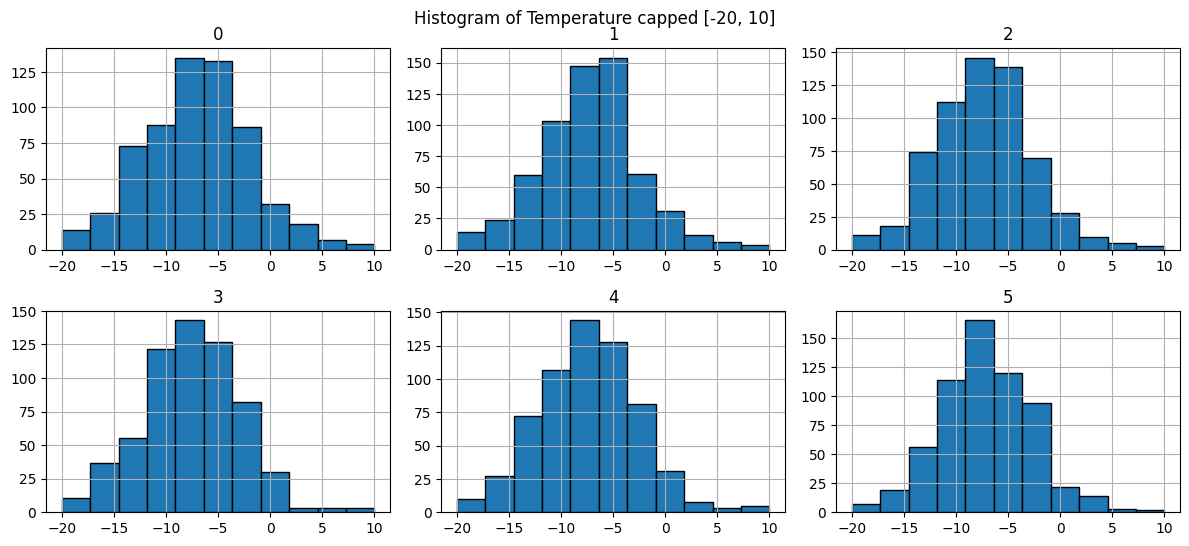

In [ ]:
temp_rows = [df.iloc[:, 0] for df in loaded_dfs]
temp_info = pd.DataFrame(temp_rows).reset_index(drop=True)
temp_info = temp_info.applymap(lambda x: min(x, 10))    # cap at 10
temp_info = temp_info.applymap(lambda x: max(x, -20))    # cap at -20


# Plot the histogram
temp_info.hist(figsize=(12, 16), bins=11, edgecolor='black', layout=(temp_info.shape[1], 3))
plt.suptitle('Histogram of Temperature capped [-20, 10]')
plt.tight_layout()
plt.show()

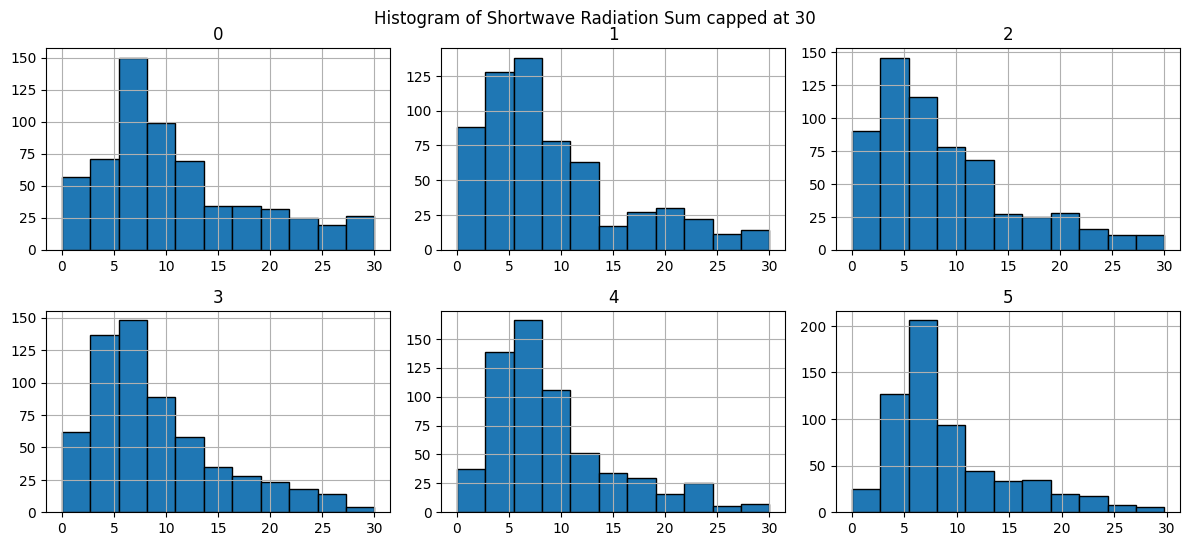

In [ ]:
srs_rows = [df.iloc[:, 3] for df in loaded_dfs]
srs_info = pd.DataFrame(srs_rows).reset_index(drop=True)
srs_info = srs_info.applymap(lambda x: min(x, 30))    # cap at 10
# srs_info = srs_info.applymap(lambda x: max(x, -20))    # cap at -20


# Plot the histogram
srs_info.hist(figsize=(12, 16), bins=11, edgecolor='black', layout=(srs_info.shape[1], 3))
plt.suptitle('Histogram of Shortwave Radiation Sum capped at 30')
plt.tight_layout()
plt.xlabel("MJ / m2")
plt.show()

# Learning Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [ ]:
weather_fp = 'drive/MyDrive/Colab/weather_dfs.pkl'
with open(weather_fp, 'rb') as f:
    weather_dfs = pickle.load(f)

eaws_path = 'drive/MyDrive/Colab/eaws.csv'
df_eaws = getAvalanchesData(eaws_path, 2016)

df_weather0 = weather_dfs[0]

print(len(weather_dfs), df_weather0.shape)
print(dfa.shape)

616 (6, 6)
(616, 23)


In [ ]:
# fill nans
df_eaws['fatal'] = df_eaws['fatal'].fillna(0)
df_eaws['danger_level'] = df_eaws['danger_level'].fillna(0)
df_eaws['group_size'] = df_eaws['group_size'].fillna(df_eaws['fatal'])

# Drop NaN rows and extract their indices
nan_indices = df_eaws[df_eaws['av_problem1'].isna()].index
df_eaws = df_eaws.dropna(subset=['av_problem1'])

# Remove corresponding weather dfs
weather_dfs = [weather_dfs[i] for i in range(len(weather_dfs)) if i not in nan_indices]
assert len(weather_dfs) == df_eaws.shape[0]

In [ ]:
# Prepare the data
X_avalanche = df_eaws.loc[:, ["fatal", "group_size", "danger_level"]].values
y = df_eaws['av_problem1'].values

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
y_categorical.shape
assert y_categorical.shape[0] == len(weather_dfs)

In [ ]:
# Standardize avalanche data
scaler_avalanche = StandardScaler()
X_avalanche = scaler_avalanche.fit_transform(X_avalanche)

# Standardize weather data
weather_shape = weather_dfs[0].shape
X_weather = np.array([StandardScaler().fit_transform(df) for df in weather_dfs])
X_weather = X_weather.reshape((len(weather_dfs), weather_shape[0], weather_shape[1]))


# Split data into training and testing sets
X_avalanche_train, X_avalanche_test, X_weather_train, X_weather_test, y_train, y_test = train_test_split(
    X_avalanche, X_weather, y_categorical, test_size=0.2, random_state=42
)

In [ ]:
def roc():
    # Convert labels to binary format
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    # Predict probabilities for each class
    y_pred_prob = model.predict([X_avalanche_test, X_weather_test])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(label_encoder.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(10, 7))
    for i in range(len(label_encoder.classes_)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

### LSTM

In [ ]:
# Define the LSTM model
avalanche_input = Input(shape=(X_avalanche_train.shape[1],))
weather_input = Input(shape=(weather_shape[0], weather_shape[1]))

lstm_out = LSTM(64)(weather_input)
combined = Concatenate()([avalanche_input, lstm_out])

dense1 = Dense(64, activation='relu')(combined)
output = Dense(5, activation='softmax')(dense1)  # 5 classes, so 5 output units with softmax activation

model = Model(inputs=[avalanche_input, weather_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_avalanche_train, X_weather_train], y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate([X_avalanche_test, X_weather_test], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict and evaluate
y_pred = model.predict([X_avalanche_test, X_weather_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


Epoch 1/50
10/10 [==============================] - 3s 68ms/step - loss: 1.5414 - accuracy: 0.3101 - val_loss: 1.5552 - val_accuracy: 0.3291
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 1.4597 - accuracy: 0.3861 - val_loss: 1.4711 - val_accuracy: 0.4557
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 1.3752 - accuracy: 0.4494 - val_loss: 1.3642 - val_accuracy: 0.5316
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - loss: 1.2804 - accuracy: 0.4715 - val_loss: 1.2314 - val_accuracy: 0.5696
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 1.2101 - accuracy: 0.4937 - val_loss: 1.1721 - val_accuracy: 0.5823
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 1.1771 - accuracy: 0.5127 - val_loss: 1.1668 - val_accuracy: 0.5823
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 1.1500 - accuracy: 0.5127 - val_loss: 1.1409 - val_accuracy: 0.5949
Epoch 8/50
10/10 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 4ms/step - loss: 1.8578 - accuracy: 0.4848
Test Accuracy: 0.4848484992980957
4/4 [==============================] - 0s 3ms/step
                       precision    recall  f1-score   support

         Gliding snow       0.00      0.00      0.00         2
             New snow       0.42      0.38      0.40        13
Persistent weak layer       0.26      0.53      0.35        17
             Wet snow       0.50      0.20      0.29        10
            Wind slab       0.67      0.56      0.61        57

             accuracy                           0.48        99
            macro avg       0.37      0.34      0.33        99
         weighted avg       0.53      0.48      0.49        99



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


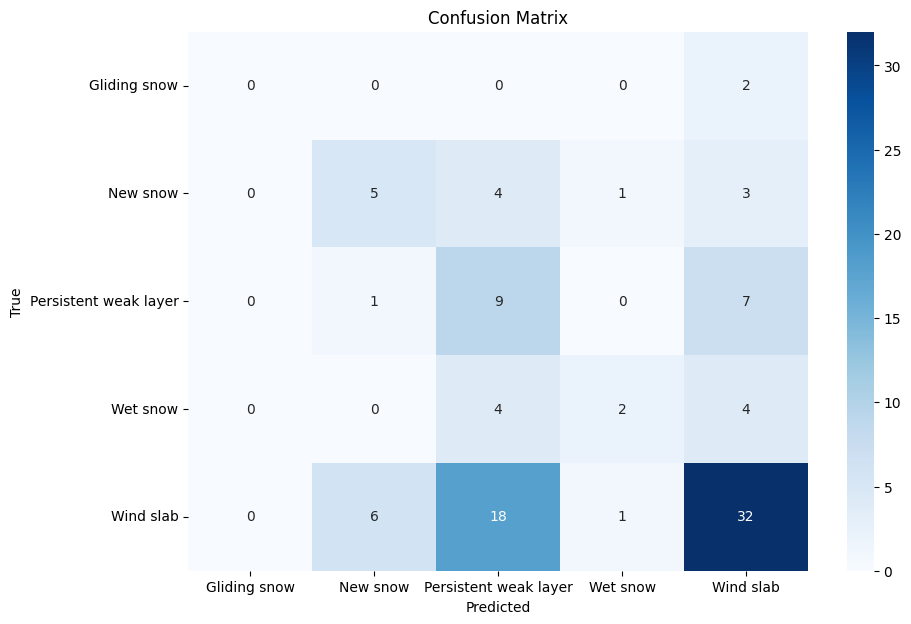

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([X_avalanche_test, X_weather_test], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict and evaluate
y_pred = model.predict([X_avalanche_test, X_weather_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

4/4 [==============================] - 0s 3ms/step


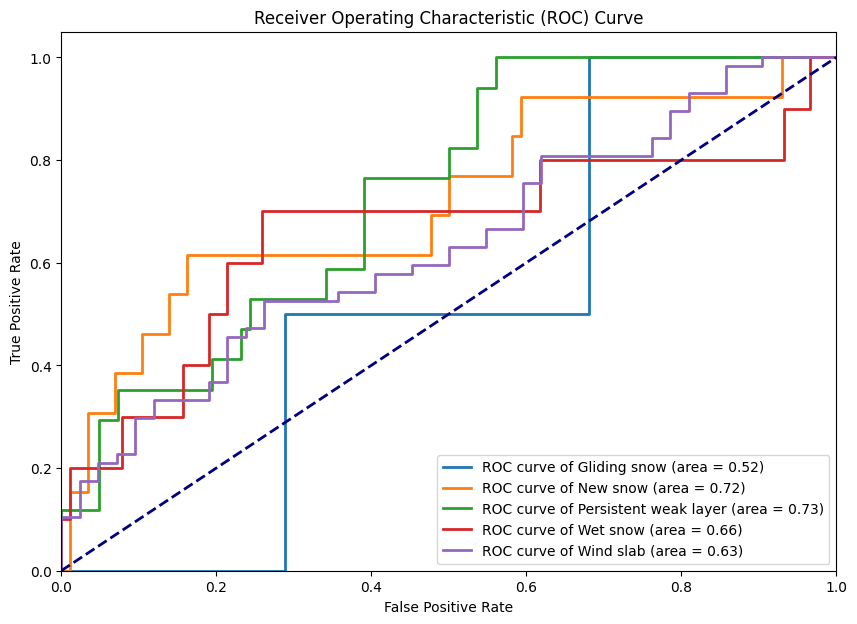

In [ ]:
roc()

## LSTM (complex)

In [ ]:
# Define the LSTM model with additional layers
avalanche_input = Input(shape=(X_avalanche_train.shape[1],))
weather_input = Input(shape=(weather_shape[0], weather_shape[1]))

lstm_out = LSTM(64, return_sequences=True)(weather_input)
lstm_out = LSTM(32)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)

combined = Concatenate()([avalanche_input, lstm_out])

dense1 = Dense(128, activation='relu')(combined)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(dense1)
dense2 = Dropout(0.3)(dense2)
output = Dense(5, activation='softmax')(dense2)  # 5 classes, so 5 output units with softmax activation

model = Model(inputs=[avalanche_input, weather_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_avalanche_train, X_weather_train], y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 6s 162ms/step - loss: 1.5034 - accuracy: 0.3006 - val_loss: 1.4558 - val_accuracy: 0.5063
Epoch 2/50
10/10 [==============================] - 0s 20ms/step - loss: 1.2751 - accuracy: 0.5032 - val_loss: 1.3744 - val_accuracy: 0.5190
Epoch 3/50
10/10 [==============================] - 0s 19ms/step - loss: 1.2148 - accuracy: 0.5095 - val_loss: 1.3415 - val_accuracy: 0.5316
Epoch 4/50
10/10 [==============================] - 0s 20ms/step - loss: 1.1845 - accuracy: 0.5032 - val_loss: 1.3349 - val_accuracy: 0.5316
Epoch 5/50
10/10 [==============================] - 0s 20ms/step - loss: 1.1447 - accuracy: 0.5222 - val_loss: 1.3271 - val_accuracy: 0.5570
Epoch 6/50
10/10 [==============================] - 0s 21ms/step - loss: 1.1051 - accuracy: 0.5475 - val_loss: 1.3067 - val_accuracy: 0.5570
Epoch 7/50
10/10 [==============================] - 0s 20ms/step - loss: 1.0546 - accuracy: 0.5601 - val_loss: 1.3024 - val_accuracy: 0.5316
Epoch 8/50
1

In [ ]:
# Evaluate the model
print(f'Test Accuracy: {accuracy}')

# Predict and evaluate
y_pred = model.predict([X_avalanche_test, X_weather_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

Test Accuracy: 0.4848484992980957
4/4 [==============================] - 1s 4ms/step
                       precision    recall  f1-score   support

         Gliding snow       0.00      0.00      0.00         2
             New snow       0.28      0.38      0.32        13
Persistent weak layer       0.42      0.65      0.51        17
             Wet snow       0.22      0.20      0.21        10
            Wind slab       0.70      0.56      0.62        57

             accuracy                           0.51        99
            macro avg       0.32      0.36      0.33        99
         weighted avg       0.53      0.51      0.51        99



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


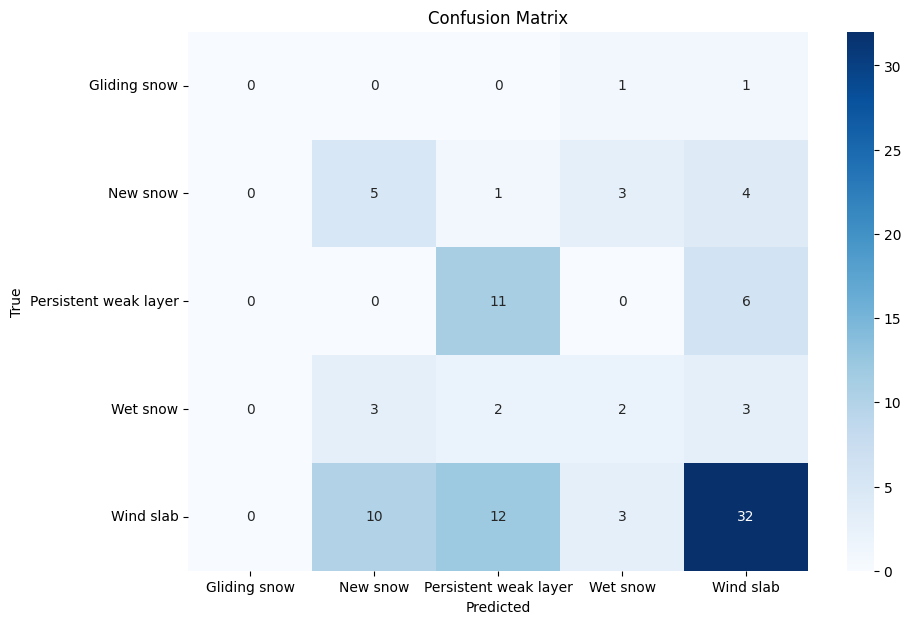

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

4/4 [==============================] - 0s 4ms/step


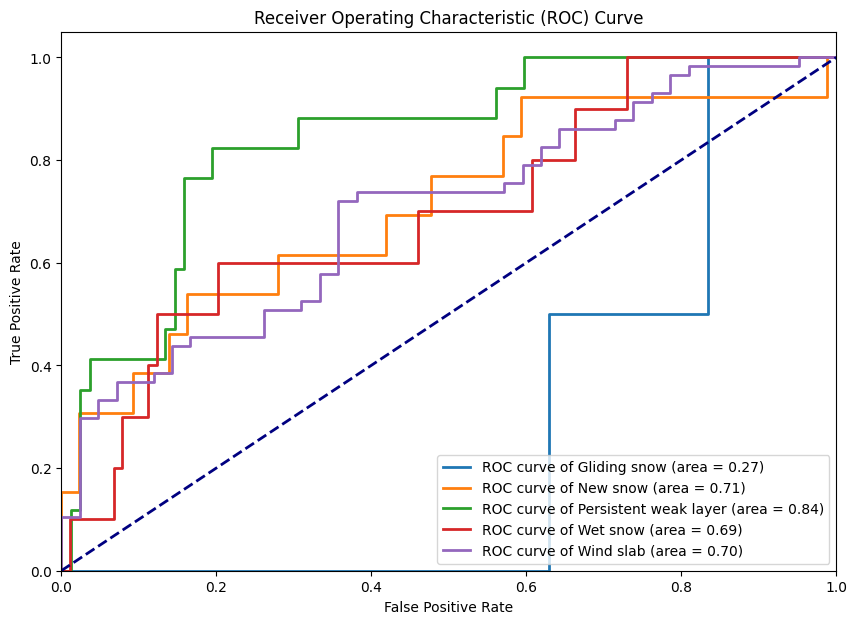

In [ ]:
roc()

## CNN (flatten)

Epoch 1/50
10/10 [==============================] - 1s 31ms/step - loss: 1.5366 - accuracy: 0.3133 - val_loss: 1.3412 - val_accuracy: 0.5190
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 1.2673 - accuracy: 0.4747 - val_loss: 1.2122 - val_accuracy: 0.5443
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 1.2069 - accuracy: 0.4873 - val_loss: 1.1962 - val_accuracy: 0.5696
Epoch 4/50
10/10 [==============================] - 0s 10ms/step - loss: 1.1560 - accuracy: 0.5190 - val_loss: 1.1689 - val_accuracy: 0.5570
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 1.1137 - accuracy: 0.5316 - val_loss: 1.1090 - val_accuracy: 0.5696
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 1.0771 - accuracy: 0.5475 - val_loss: 1.1031 - val_accuracy: 0.5823
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 1.0488 - accuracy: 0.5475 - val_loss: 1.1059 - val_accuracy: 0.5443
Epoch 8/50
10/1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


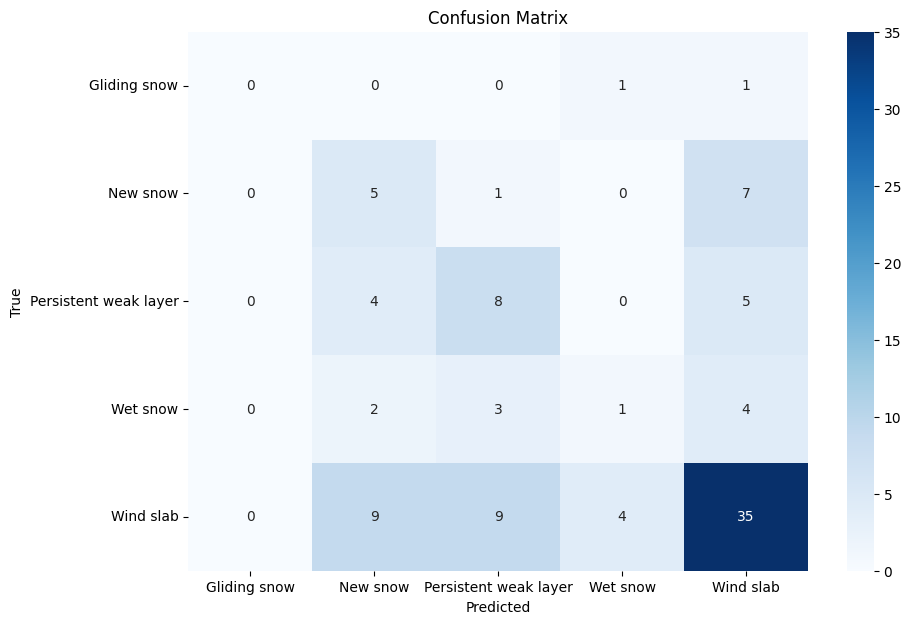

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout, BatchNormalization

# Define the CNN + Fully Connected model
avalanche_input = Input(shape=(X_avalanche_train.shape[1],))
weather_input = Input(shape=(weather_shape[0], weather_shape[1]))

# CNN for weather data
conv1 = Conv1D(32, kernel_size=2, activation='relu')(weather_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(64, kernel_size=2, activation='relu')(pool1)
flatten = Flatten()(conv2)

# Fully connected layers for avalanche data
dense_avalanche = Dense(128, activation='relu')(avalanche_input)
dense_avalanche = Dropout(0.3)(dense_avalanche)

# Concatenate the outputs of both branches
combined = Concatenate()([flatten, dense_avalanche])

# Additional dense layers
dense1 = Dense(128, activation='relu')(combined)
# dense1 = Dropout(0.3)(dense1)
# dense2 = Dense(64, activation='relu')(dense1)
# dense2 = Dropout(0.3)(dense2)
output = Dense(5, activation='softmax')(dense1)  # 5 classes, so 5 output units with softmax activation

model = Model(inputs=[avalanche_input, weather_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_avalanche_train, X_weather_train], y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate([X_avalanche_test, X_weather_test], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict and evaluate
y_pred = model.predict([X_avalanche_test, X_weather_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

4/4 [==============================] - 0s 3ms/step


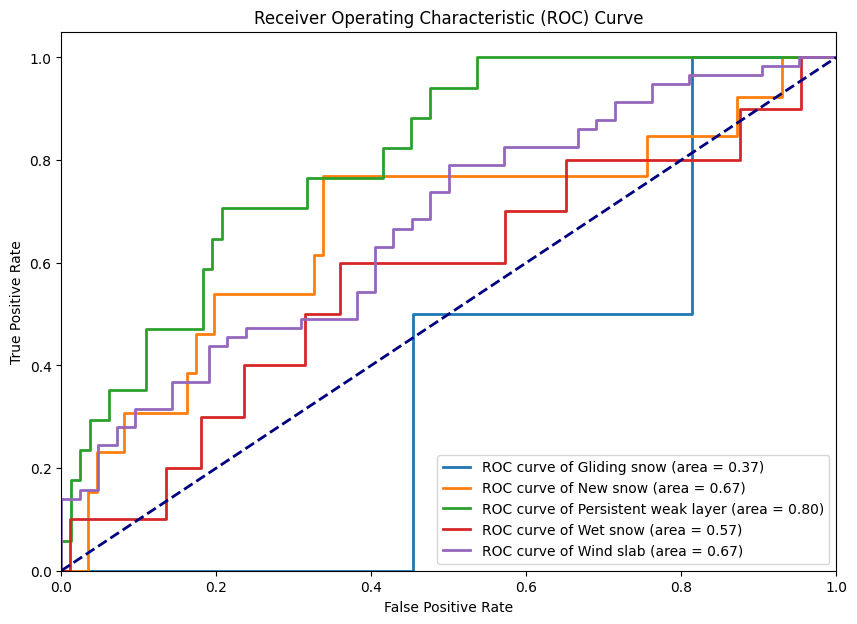

In [ ]:
roc()

## CNN (complex)

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout, BatchNormalization

# Define the CNN + Fully Connected model
avalanche_input = Input(shape=(X_avalanche_train.shape[1],))
weather_input = Input(shape=(weather_shape[0], weather_shape[1]))

# CNN for weather data
conv1 = Conv1D(32, kernel_size=2, activation='relu')(weather_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(64, kernel_size=2, activation='relu')(pool1)
flatten = Flatten()(conv2)

# Fully connected layers for avalanche data
dense_avalanche = Dense(128, activation='relu')(avalanche_input)
dense_avalanche = Dropout(0.3)(dense_avalanche)

# Concatenate the outputs of both branches
combined = Concatenate()([flatten, dense_avalanche])

# Additional dense layers
dense1 = Dense(128, activation='relu')(combined)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(dense1)
dense2 = Dropout(0.3)(dense2)
output = Dense(5, activation='softmax')(dense1)  # 5 classes, so 5 output units with softmax activation

model = Model(inputs=[avalanche_input, weather_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_avalanche_train, X_weather_train], y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 1s 31ms/step - loss: 1.4993 - accuracy: 0.3101 - val_loss: 1.3048 - val_accuracy: 0.5443
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 1.3159 - accuracy: 0.4620 - val_loss: 1.2071 - val_accuracy: 0.5316
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 1.2312 - accuracy: 0.4905 - val_loss: 1.1819 - val_accuracy: 0.5190
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 1.1919 - accuracy: 0.5158 - val_loss: 1.1583 - val_accuracy: 0.5443
Epoch 5/50
10/10 [==============================] - 0s 6ms/step - loss: 1.1719 - accuracy: 0.5127 - val_loss: 1.1136 - val_accuracy: 0.5570
Epoch 6/50
10/10 [==============================] - 0s 7ms/step - loss: 1.1059 - accuracy: 0.5443 - val_loss: 1.0843 - val_accuracy: 0.5570
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 1.0872 - accuracy: 0.5601 - val_loss: 1.0863 - val_accuracy: 0.5696
Epoch 8/50
10/10 [=

4/4 [==============================] - 0s 6ms/step - loss: 1.9707 - accuracy: 0.5354
Test Accuracy: 0.5353535413742065
4/4 [==============================] - 0s 3ms/step
                       precision    recall  f1-score   support

         Gliding snow       0.00      0.00      0.00         2
             New snow       0.33      0.31      0.32        13
Persistent weak layer       0.40      0.47      0.43        17
             Wet snow       0.29      0.40      0.33        10
            Wind slab       0.70      0.65      0.67        57

             accuracy                           0.54        99
            macro avg       0.34      0.37      0.35        99
         weighted avg       0.54      0.54      0.54        99



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


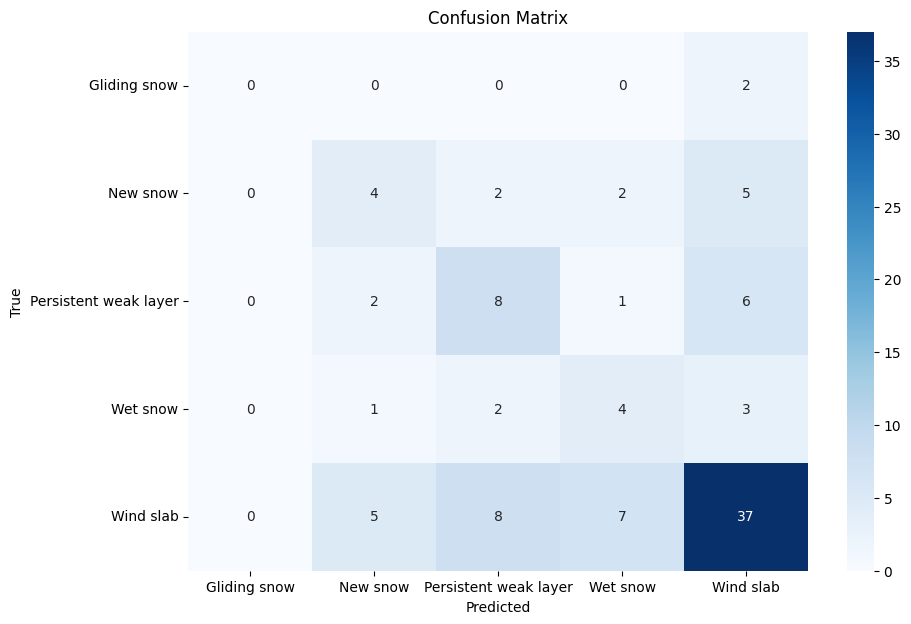

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([X_avalanche_test, X_weather_test], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict and evaluate
y_pred = model.predict([X_avalanche_test, X_weather_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

4/4 [==============================] - 0s 3ms/step


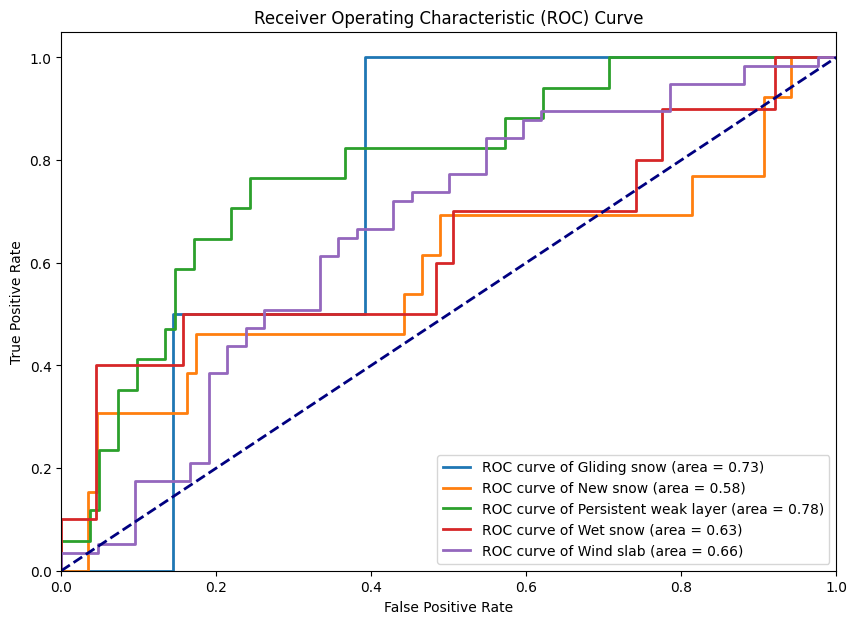

In [ ]:
roc()

# Extend

- relu -> lrelu
- mini-batch -> batch
- 1 vs all (for wind slab)
- remove gliding snow
- fetch more weather data, do not compress it (or compress less)